In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

np.random.seed(42)
random.seed(42)

In [ ]:

data_dir = "/kaggle/input/animal-dataset/animal_dataset"

CATEGORIES = []
for c in os.listdir(data_dir):
    CATEGORIES.append(c)

print("\nClasses:", CATEGORIES)
print("Total number of classes:", len(CATEGORIES))


counts = {}
for c in CATEGORIES:
    folder = os.path.join(data_dir, c)
    files = [f for f in os.listdir(folder)]
    counts[c] = len(files)

print("\nImage counts per class:")
for class_name, count in counts.items():
    print(f"   {class_name}: {count} images")

total_images = sum(counts.values())
print(f"\nTotal images: {total_images}")


Classes: ['dog', 'panda', 'cat']
Total number of classes: 3

Image counts per class:
   dog: 100 images
   panda: 100 images
   cat: 100 images

Total images: 300


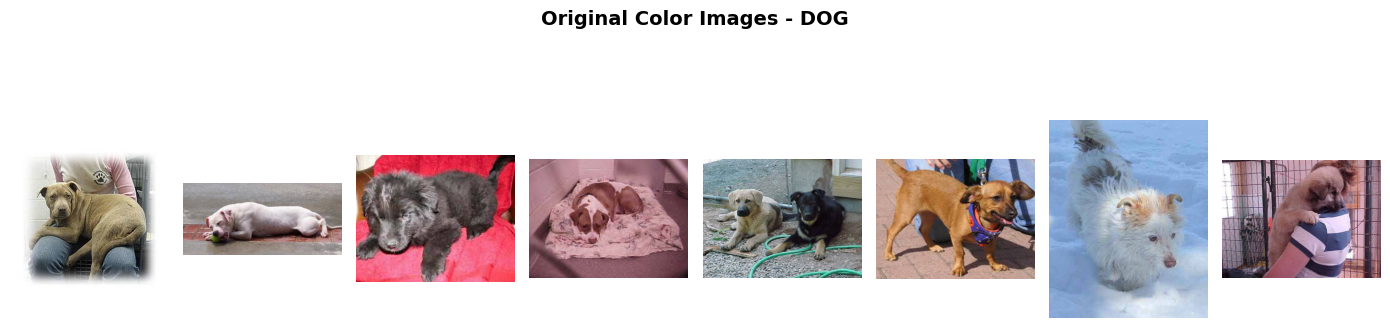

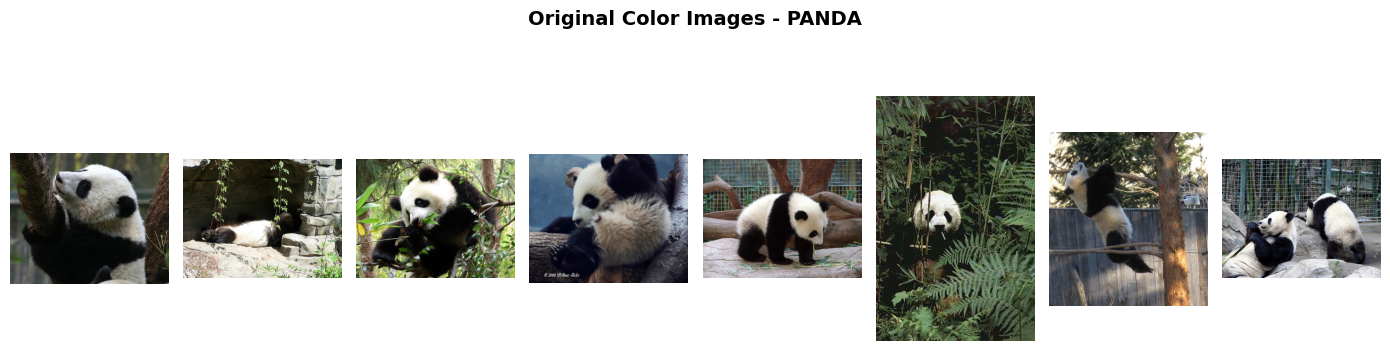

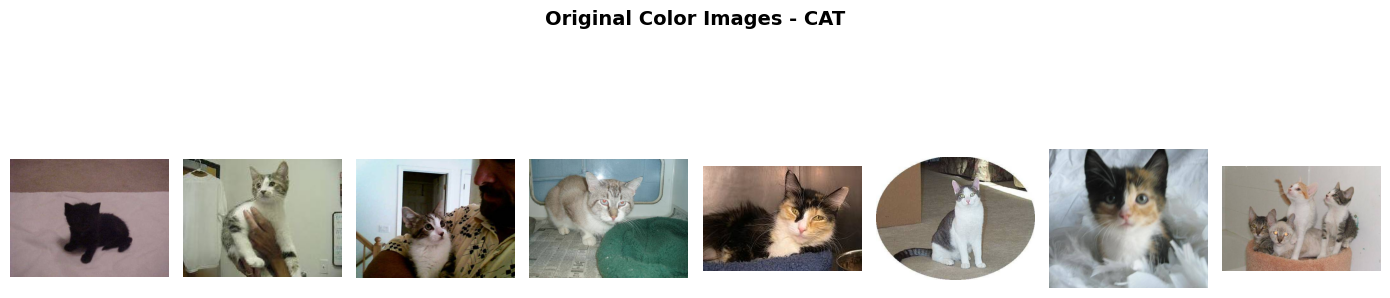

In [ ]:


for category in CATEGORIES:
    path = os.path.join(data_dir, category)
    fig, axes = plt.subplots(1, 8, figsize=(14, 4))
    fig.suptitle(f"Original Color Images - {category.upper()}",
                 fontsize=14, fontweight='bold')

    image_files = os.listdir(path)[:8]
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(path, img_file)
        img = plt.imread(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:

IMG_SIZE = 32
TRAIN_DATA = []

for category in CATEGORIES:
    path = os.path.join(data_dir, category)
    class_num = CATEGORIES.index(category)
    class_count = 0

    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        TRAIN_DATA.append([img_gray, class_num])
        class_count += 1

    print(f"✓ {category}: Loaded {class_count} images")

print(f"\n✓ Total images loaded: {len(TRAIN_DATA)}")
print(f"   Image size: {IMG_SIZE} x {IMG_SIZE} pixels (grayscale)")

✓ dog: Loaded 100 images
✓ panda: Loaded 100 images
✓ cat: Loaded 100 images

✓ Total images loaded: 300
   Image size: 32 x 32 pixels (grayscale)


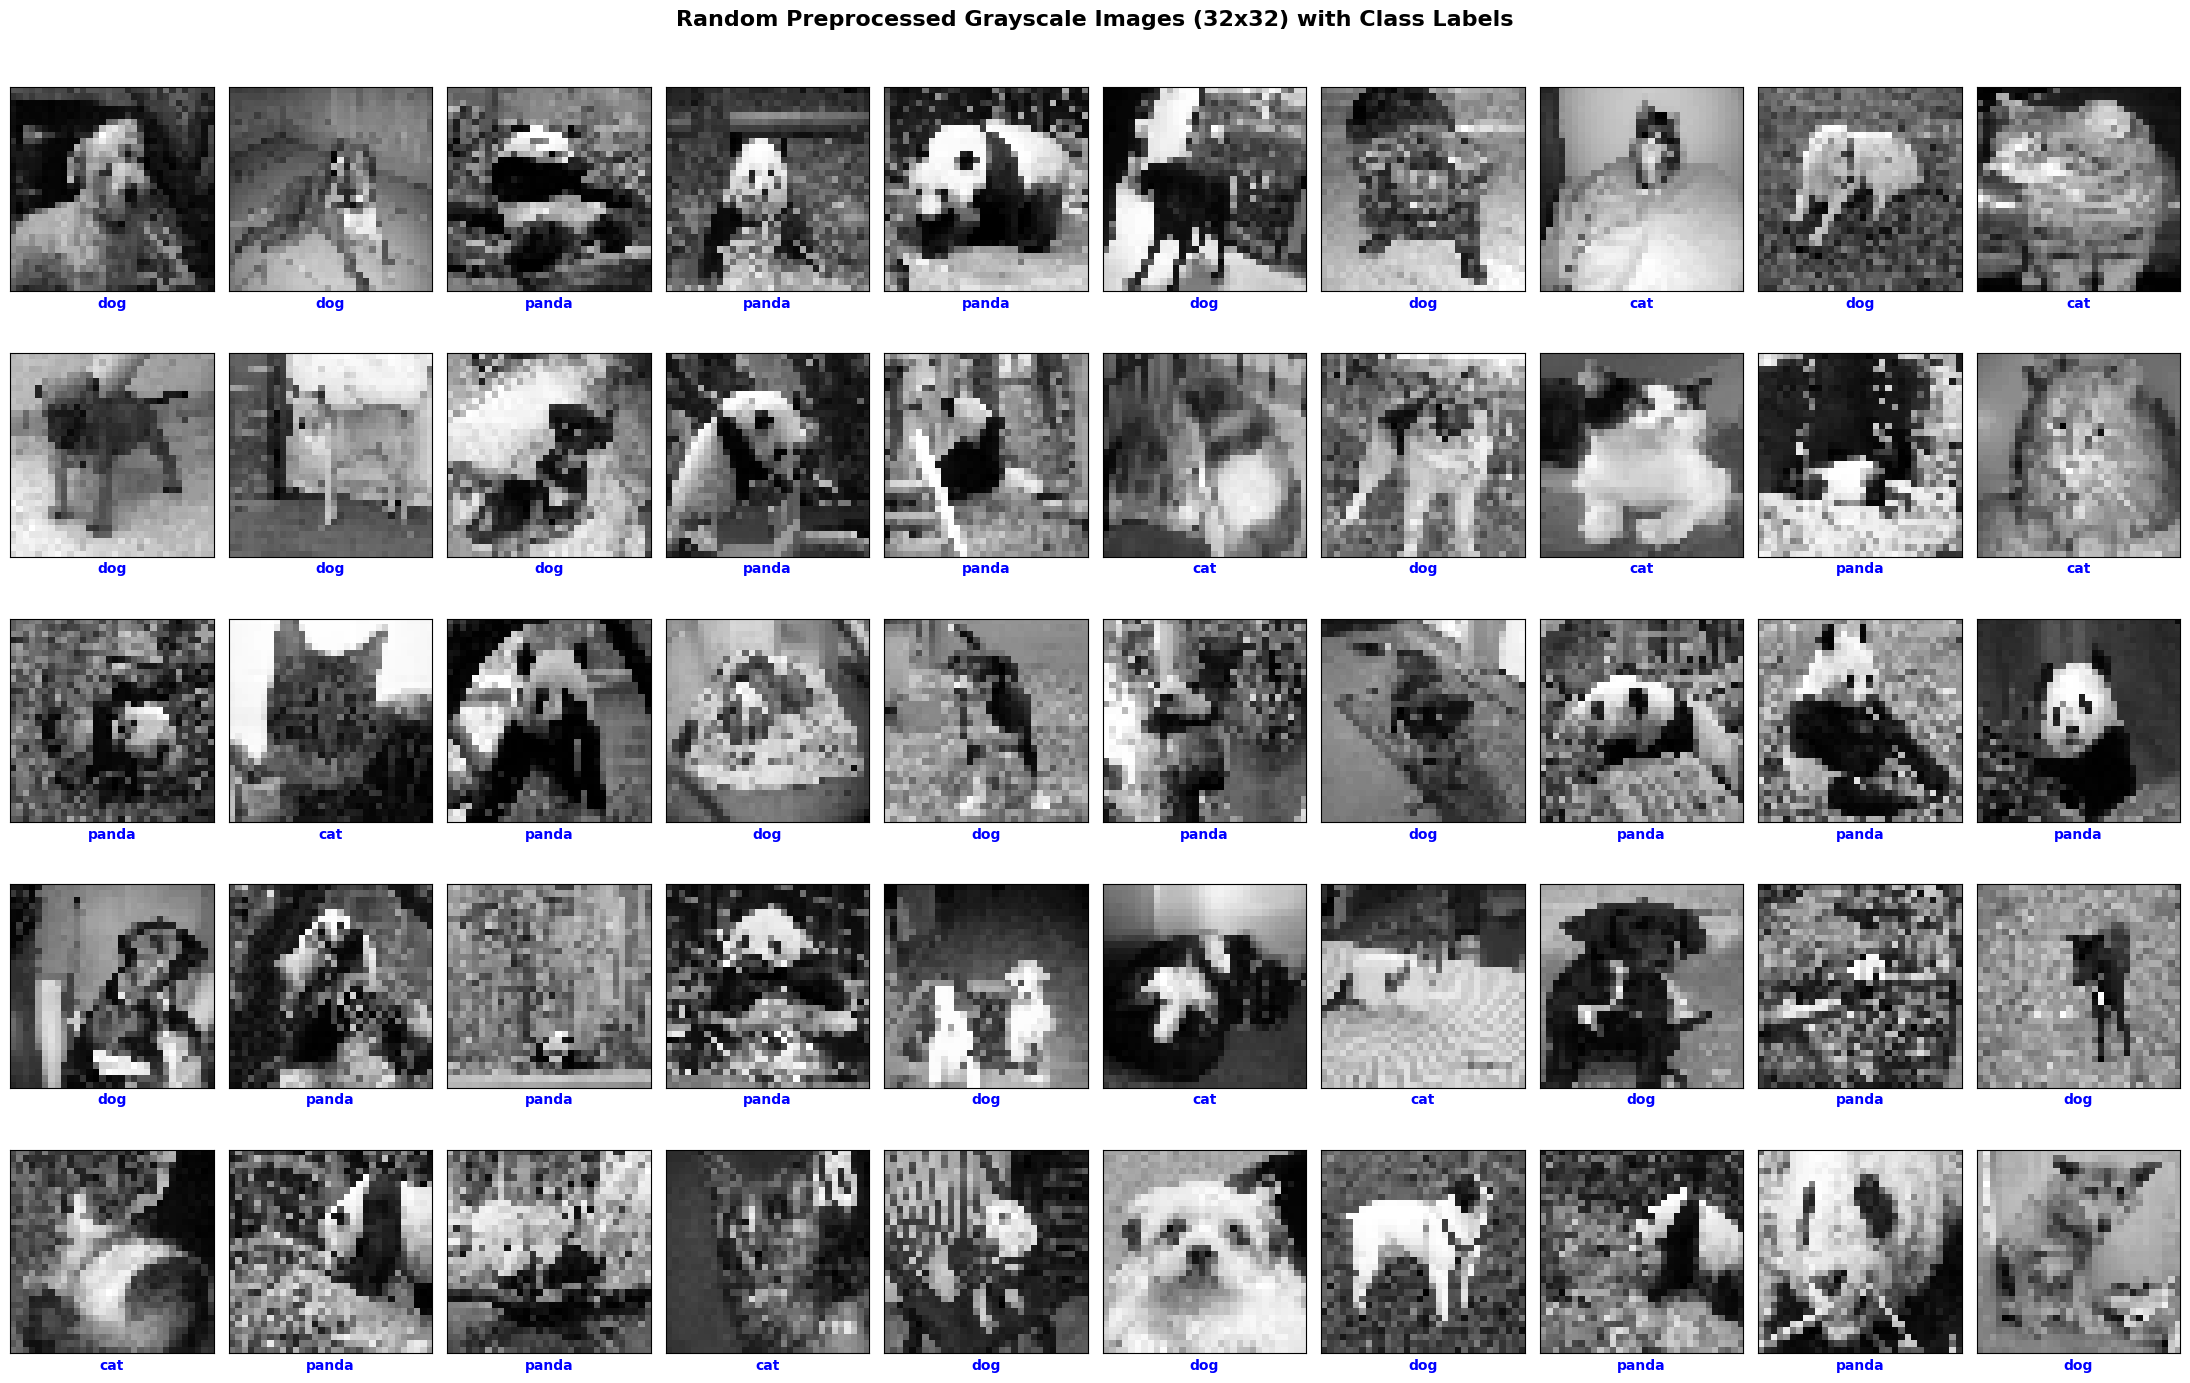

In [ ]:


fig = plt.figure(figsize=(22, 14))
random_indices = random.sample(range(len(TRAIN_DATA)), 50)

for i, idx in enumerate(random_indices):
    plt.subplot(5, 10, i + 1)
    gray_img, label = TRAIN_DATA[idx]
    class_name = CATEGORIES[label]

    plt.imshow(gray_img, cmap="gray")
    plt.xlabel(class_name, fontsize=10, fontweight='bold', color='blue')
    plt.xticks([])
    plt.yticks([])

fig.suptitle("Random Preprocessed Grayscale Images (32x32) with Class Labels",
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [ ]:


features = []
labels = []

for img, label in TRAIN_DATA:
    img_flat = img.flatten().astype(np.float32) / 255.0
    features.append(img_flat)
    labels.append(label)

features = np.array(features)
labels = np.array(labels)

print(f"\n✓ Features shape: {features.shape}")
print(f"✓ Labels shape: {labels.shape}")
print(f"✓ Feature range: [{features.min():.3f}, {features.max():.3f}]")
print(f"✓ Unique classes: {np.unique(labels)}")


✓ Features shape: (300, 1024)
✓ Labels shape: (300,)
✓ Feature range: [0.000, 1.000]
✓ Unique classes: [0 1 2]


In [ ]:



data = list(zip(features, labels))
random.shuffle(data)


n_folds = 5
fold_size = len(data) // n_folds
folds = [data[i * fold_size : (i + 1) * fold_size] for i in range(n_folds)]


remainder = len(data) % n_folds
for i in range(remainder):
    folds[i].append(data[n_folds * fold_size + i])

print("\n✓ Fold sizes:")
for i, fold in enumerate(folds):
    print(f"   Fold {i+1}: {len(fold)} samples")


✓ Fold sizes:
   Fold 1: 60 samples
   Fold 2: 60 samples
   Fold 3: 60 samples
   Fold 4: 60 samples
   Fold 5: 60 samples


In [ ]:


def manhattan_distance(vec1, vec2):

    return np.sum(np.abs(vec1 - vec2))

def euclidean_distance(vec1, vec2):

    return np.sqrt(np.sum((vec1 - vec2) ** 2))



d_l1 = manhattan_distance(features[0], features[1])
d_l2 = euclidean_distance(features[0], features[1])
print(f"Test L1 distance: {d_l1:.4f}")
print(f"Test L2 distance: {d_l2:.4f}")

same_image_d1 = manhattan_distance(features[10], features[10])
print(f"Test L1 distance of same feature/image:{same_image_d1:.4f}")

Test L1 distance: 296.4785
Test L2 distance: 10.5689
Test L1 distance of same feature/image:0.0000


In [ ]:


def knn_predict(X_train, y_train, x_test, k=5, distance_type='l2'):
    distances = []


    for i in range(len(X_train)):
        if distance_type == 'l1':
            dist = manhattan_distance(X_train[i], x_test)
        else:
            dist = euclidean_distance(X_train[i], x_test)
        distances.append((dist, y_train[i]))


    distances.sort(key=lambda x: x[0])


    k_labels = [label for _, label in distances[:k]]


    label_count = {}
    for label in k_labels:
        label_count[label] = label_count.get(label, 0) + 1


    most_common = max(label_count, key=label_count.get)

    return most_common


In [ ]:

def run_knn_cross_validation(folds, k_values, distance_type='l2'):
    fold_wise_accuracies = []

    for fold_index in range(len(folds)):
        validation_data = folds[fold_index]
        training_data = []
        for i in range(len(folds)):
            if i != fold_index:
                training_data.extend(folds[i])

        X_train = np.array([item[0] for item in training_data])
        y_train = np.array([item[1] for item in training_data])
        X_val = np.array([item[0] for item in validation_data])
        y_val = np.array([item[1] for item in validation_data])

        fold_accuracies = []

        for k in k_values:
            correct = 0
            for i in range(len(X_val)):
                pred = knn_predict(X_train, y_train, X_val[i], k=k,
                                  distance_type=distance_type)
                if pred == y_val[i]:
                    correct += 1
            accuracy = correct / len(X_val)
            fold_accuracies.append(accuracy)

        fold_wise_accuracies.append(fold_accuracies)
        print(f"✓ Fold {fold_index + 1}/5 completed")

    avg_accuracies = np.mean(fold_wise_accuracies, axis=0)
    return fold_wise_accuracies, avg_accuracies


K_values = np.arange(1, 26)

print(f"K values to test: {list(K_values)}")
print("--- Manhattan (L1) Distance ---")
fold_acc_l1, avg_acc_l1 = run_knn_cross_validation(folds, K_values, distance_type='l1')

print("--- Euclidean (L2) Distance ---")
fold_acc_l2, avg_acc_l2 = run_knn_cross_validation(folds, K_values, distance_type='l2')

K values to test: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
--- Manhattan (L1) Distance ---
✓ Fold 1/5 completed
✓ Fold 2/5 completed
✓ Fold 3/5 completed
✓ Fold 4/5 completed
✓ Fold 5/5 completed
--- Euclidean (L2) Distance ---
✓ Fold 1/5 completed
✓ Fold 2/5 completed
✓ Fold 3/5 completed
✓ Fold 4/5 completed
✓ Fold 5/5 completed


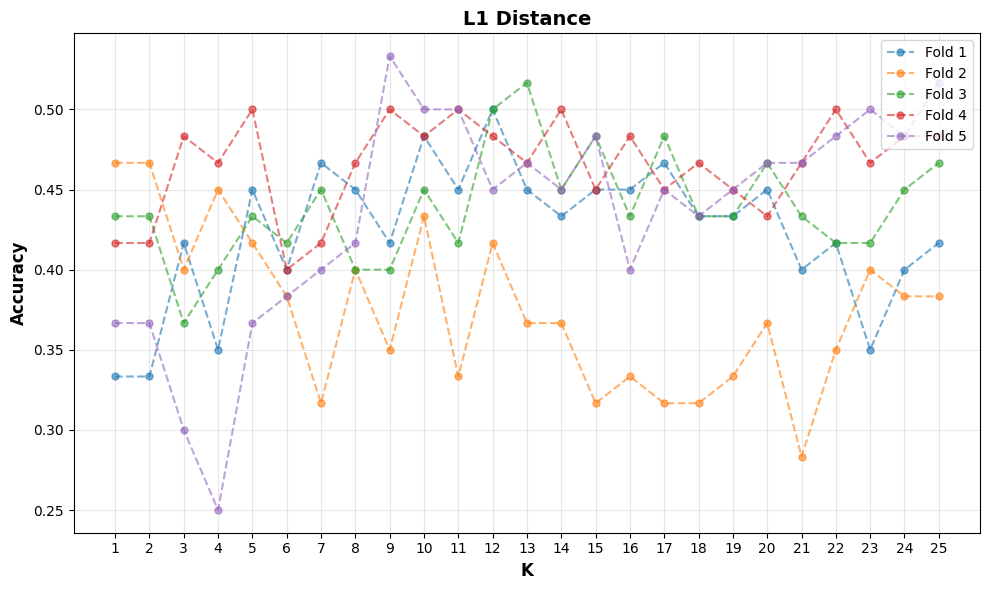

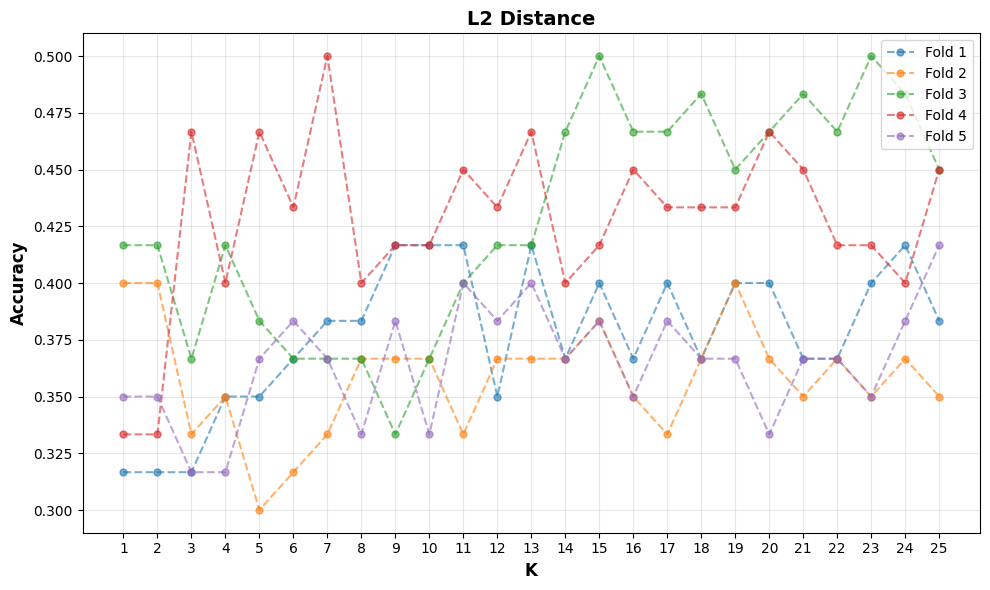

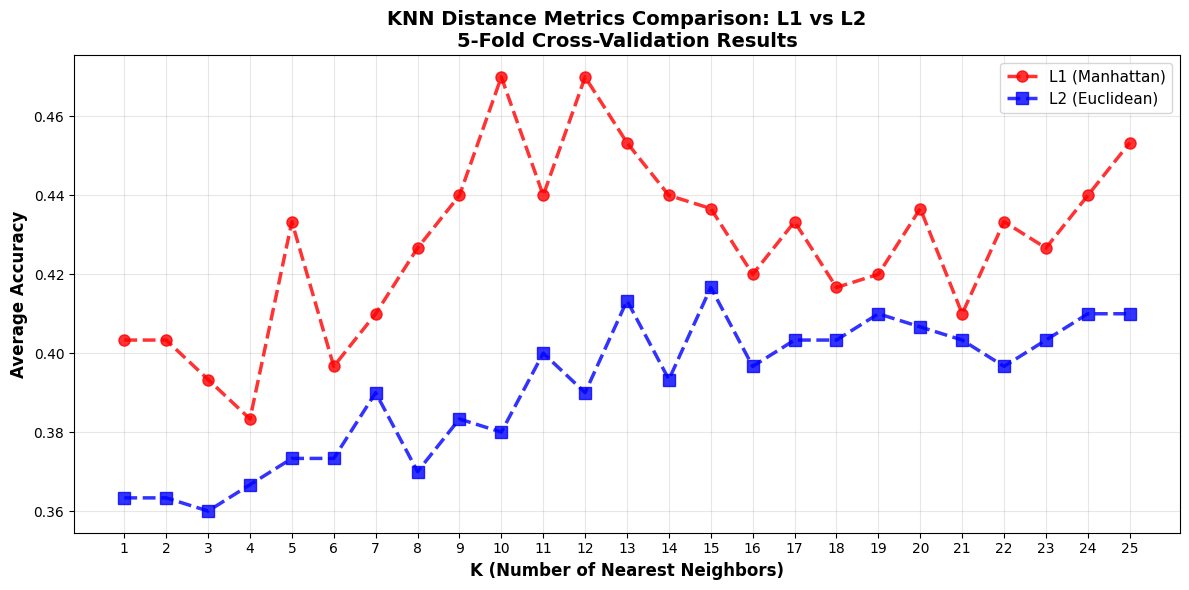

In [ ]:

fold_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']


fig, ax = plt.subplots(figsize=(10, 6))

for i, acc in enumerate(fold_acc_l1):
    ax.plot(K_values, acc, 'o--', color=fold_colors[i], alpha=0.6,
            linewidth=1.5, markersize=5, label=f'Fold {i+1}')

ax.set_xlabel('K', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('L1 Distance', fontsize=14, fontweight='bold')
ax.set_xticks(K_values)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(10, 6))

for i, acc in enumerate(fold_acc_l2):
    ax.plot(K_values, acc, 'o--', color=fold_colors[i], alpha=0.6,
            linewidth=1.5, markersize=5, label=f'Fold {i+1}')

ax.set_xlabel('K', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('L2 Distance', fontsize=14, fontweight='bold')
ax.set_xticks(K_values)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(K_values, avg_acc_l1, 'o--', color='red', linewidth=2.5,
        markersize=8, label='L1 (Manhattan)', alpha=0.8)
ax.plot(K_values, avg_acc_l2, 's--', color='blue', linewidth=2.5,
        markersize=8, label='L2 (Euclidean)', alpha=0.8)

ax.set_xlabel('K (Number of Nearest Neighbors)', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Accuracy', fontsize=12, fontweight='bold')
ax.set_title('KNN Distance Metrics Comparison: L1 vs L2\n5-Fold Cross-Validation Results',
            fontsize=14, fontweight='bold')
ax.set_xticks(K_values)
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=11)
plt.tight_layout()
plt.show()

In [ ]:

print("Average Accuracy for Manhattan (L1):")
for k, acc in zip(K_values, avg_acc_l1):
    print(f"K = {k:2d} : {acc*100:.2f}%")

print("Average Accuracy for Euclidean (L2):")
for k, acc in zip(K_values, avg_acc_l2):
    print(f"K = {k:2d} : {acc*100:.2f}%")

best_k_l1 = K_values[np.argmax(avg_acc_l1)]
best_acc_l1 = max(avg_acc_l1)
best_k_l2 = K_values[np.argmax(avg_acc_l2)]
best_acc_l2 = max(avg_acc_l2)

print("BEST RESULTS")
print(f"Manhattan (L1) Distance:")
print(f"Best K: {best_k_l1}")
print(f"Best Accuracy: {best_acc_l1:.4f} ({best_acc_l1*100:.2f}%)")

print(f"Euclidean (L2) Distance:")
print(f"Best K: {best_k_l2}")
print(f"Best Accuracy: {best_acc_l2:.4f} ({best_acc_l2*100:.2f}%)")

if best_acc_l2 > best_acc_l1:
    winner = "Euclidean (L2)"
    diff = (best_acc_l2 - best_acc_l1) * 100
else:
    winner = "Manhattan (L1)"
    diff = (best_acc_l1 - best_acc_l2) * 100

print(f"\n✓ WINNER: {winner} performs better by {diff:.2f}%")

Average Accuracy for Manhattan (L1):
K =  1 : 40.33%
K =  2 : 40.33%
K =  3 : 39.33%
K =  4 : 38.33%
K =  5 : 43.33%
K =  6 : 39.67%
K =  7 : 41.00%
K =  8 : 42.67%
K =  9 : 44.00%
K = 10 : 47.00%
K = 11 : 44.00%
K = 12 : 47.00%
K = 13 : 45.33%
K = 14 : 44.00%
K = 15 : 43.67%
K = 16 : 42.00%
K = 17 : 43.33%
K = 18 : 41.67%
K = 19 : 42.00%
K = 20 : 43.67%
K = 21 : 41.00%
K = 22 : 43.33%
K = 23 : 42.67%
K = 24 : 44.00%
K = 25 : 45.33%
Average Accuracy for Euclidean (L2):
K =  1 : 36.33%
K =  2 : 36.33%
K =  3 : 36.00%
K =  4 : 36.67%
K =  5 : 37.33%
K =  6 : 37.33%
K =  7 : 39.00%
K =  8 : 37.00%
K =  9 : 38.33%
K = 10 : 38.00%
K = 11 : 40.00%
K = 12 : 39.00%
K = 13 : 41.33%
K = 14 : 39.33%
K = 15 : 41.67%
K = 16 : 39.67%
K = 17 : 40.33%
K = 18 : 40.33%
K = 19 : 41.00%
K = 20 : 40.67%
K = 21 : 40.33%
K = 22 : 39.67%
K = 23 : 40.33%
K = 24 : 41.00%
K = 25 : 41.00%
BEST RESULTS
Manhattan (L1) Distance:
Best K: 10
Best Accuracy: 0.4700 (47.00%)
Euclidean (L2) Distance:
Best K: 15
Best Accur

## **Discussion**

### **Key Findings**

**1. Effect of K on Accuracy**  
- Accuracy varies with K and shows multiple peaks.  
- Best performance occurs around **K = 10–12**.  
- Very large K mixes samples from different classes, lowering accuracy.

**2. L1 vs L2 Distance**  
- **L1 (Manhattan)** consistently performs better than L2 across most K values.  
- L1 peaks near K = 10 and 12, showing the highest accuracy in the plot.  
- L1 handles pixel-level noise better, making it more suitable for raw grayscale images.


### **Limitations**
- KNN is computationally expensive during prediction.  
- Sensitive to noisy pixel features and high dimensionality (32×32 = 1024 features).  
- Accuracy highly depends on choosing the right K.


### **Potential Improvements**
- **Feature Engineering:** HOG features, edge detection, PCA.  
- **Algorithm Enhancements:** Weighted KNN, KD-tree/Ball-tree for faster search.  
- **Alternative Models:** CNNs, SVM (RBF), Random Forests.  
- **Data Augmentation:** Rotations, flips, and translations.




Using: L1 distance with K=10
(Best performing configuration from cross-validation)



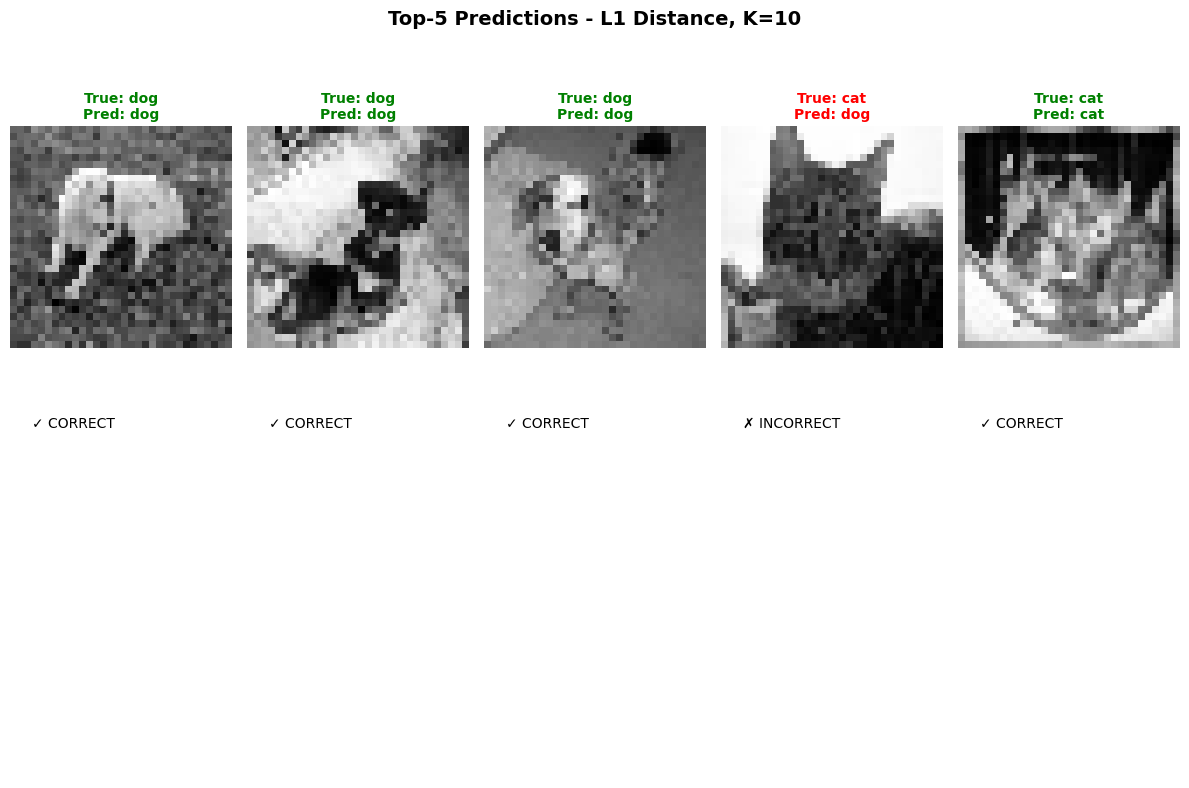

Predictions displayed!
Correct: 4/5
Accuracy: 80.00%


In [ ]:

best_metric = 'l2' if best_acc_l2 > best_acc_l1 else 'l1'
best_k = best_k_l2 if best_acc_l2 > best_acc_l1 else best_k_l1

print(f"\nUsing: {best_metric.upper()} distance with K={best_k}")
print("(Best performing configuration from cross-validation)\n")


test_data = folds[0]
train_data = []
for i in range(1, 5):
    train_data.extend(folds[i])

X_train = np.array([item[0] for item in train_data])
y_train = np.array([item[1] for item in train_data])

num_test = 5
fig, axes = plt.subplots(2, num_test, figsize=(12, 8))

correct_count = 0

for idx in range(num_test):
    x_test, y_true = test_data[idx]


    y_pred = knn_predict(X_train, y_train, x_test, k=best_k,
                        distance_type=best_metric)

    is_correct = (y_pred == y_true)
    if is_correct:
        correct_count += 1


    ax_img = axes[0, idx]
    img_display = x_test.reshape(IMG_SIZE, IMG_SIZE)
    ax_img.imshow(img_display, cmap='gray')
    ax_img.axis('off')


    border_color = 'green' if is_correct else 'red'
    for spine in ax_img.spines.values():
        spine.set_edgecolor(border_color)
        spine.set_linewidth(3)

    title = f"True: {CATEGORIES[y_true]}\nPred: {CATEGORIES[y_pred]}"
    ax_img.set_title(title, fontsize=10, fontweight='bold',
                    color=border_color)


    ax_text = axes[1, idx]
    ax_text.axis('off')

    info_text = ""

    info_text += f"{'✓ CORRECT' if is_correct else '✗ INCORRECT'}"

    ax_text.text(0.1, 0.9, info_text)

fig.suptitle(f'Top-5 Predictions - {best_metric.upper()} Distance, K={best_k}',
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Predictions displayed!")
print(f"Correct: {correct_count}/{num_test}")
print(f"Accuracy: {correct_count/num_test*100:.2f}%")